## $\mu$ & $\theta$ changing with time

We'll start with a video to give us perspective on what is happening in the code below:

[Video: Lecture 11 Thick red arrows](https://youtu.be/Z2U5MpP3PO0)

We will now return to the example in [section 5.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/5%20Basic%20bioreactor%20modeling/The%20fermenter%20equation.ipynb). We'll intoduce substrate depeletion terms (Monod functions) and product inhibition for both the $\mu$ and $\theta$ rates. As before we will start with the flux model:

<img src="etmap.png" width="570" />



Unless stated otherwise, the parameters are the same as in section 5.3. We need to define maximum values for the physiological rates ($\mu$ & $\theta$):
 
 $\mu_{max}\,\left(\frac{1}{h} \right)$|$\theta_{max} \, \left(\frac{mol\, ATP}{cmol\, X\cdot h} \right) $
 -|-
 0.12 |0.1

The parameters of the various inhibition terms are given by:

|$K_M \, \left(\frac{cmol}{L} \right)$|$K_P \, \left(\frac{cmol}{L} \right)$|$C_P^* \,  \left(\frac{cmol}{L} \right)$
 -|-|-|-
 **Growth**|0.0004|$-$|1.95
 **Maintenance**|0.00005|2.5|$-$
 
 

Note that the following equations result from the table above:

$$\mu(C_S,C_P)= \mu_{max} \left[\frac{Cs}{K_m^{\mu}+Cs} \right]   \left[ 1-\frac{C_P}{{C_P^{*}}^{\mu}} \right] $$

$$\theta(C_S,C_P)= \theta_{max} \left[\frac{Cs}{K_m^{\theta}+Cs} \right]  \left[1+\frac{C_P}{K_P^{\theta}} \right]^{-1}  $$

$C_P$ refers to the ethanol concentration since glycerol has no inhibitory effect. 

We'll start by defining the parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
α, β, γ = 0.1, 0.1,1.8 #for the greek symbols -> \alpha + Tab = α, etc...
Km_μ, Km_θ = 0.0004, 0.00005
Cp_star, Kp = 1.95, 2.5  
μmax, θmax = 0.12, 0.1

The response function (or rate function) will now be altered to include the $\mu$ and $\theta$ functions. We'll only use the function for $\mu$ up to the point where a zero value is obtained:

In [2]:
def response_fun(C):
    
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]   #Same component order as in the ferm-eq
    Cp = Ce                                #Ethanol is Cp 
    
    μ1 = μmax * Cs / (Km_μ + Cs) * (1 - Cp / Cp_star)
    θ = θmax * Cs / (Km_θ + Cs) * (1 + Cp / Kp)**(-1)
    
    if μ1 < 0.0001:   #Negative values of mu set to zero
        μ = 0 
    else:
        μ = μ1
                 
    S = np.matrix([[-1, 1 + α, 1, 0, 0],
                   [0, 0, -1, 1, 1.5],
                   [0, β, 0, -1/3, 0],
                   [0,-γ,-1/3, 0, 1],
                   [0, 1, 0, 0, 0]])

    K = np.matrix([0, 0, 0, θ, μ]).T
    r = np.linalg.solve(S, K) 
        
    
    return [r[1,0],   # important to see the order of the rates (X,S,G,E)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[3,0],   # glycerol
            r[4,0],   # ethanol   
            θ]

Note that the response function returns the rates for a given set of concentrations in the fermenter. The response function also returns $\theta$. Let's define an arbitrary condition in the fermenter where $C_S= 60 \frac{g}{L}$, $C_X= 12 \frac{g}{L}$, $C_G= 0 \frac{g}{L}$ and $C_E=C_P= 20 \frac{g}{L}$. We can calculate the rates for this specific fermenter condition:

In [3]:
rate1 = response_fun([12/24.6, 60/30, 0, 20/23])
rate1

[0.06647499931451838,
 -0.6945475759173513,
 0.019942499794355518,
 0.40098838458468367,
 0.07419169359475691]

Can you see that the rate of ethanol production ($r_E$) is $0.40 \frac{\text{cmol Et}}{\text{cmol X}\cdot \text{h}}$? Can you see that both $\mu$ and $\theta$ is not at their maximum values anymore? 

We can even calculate the yield at these conditions. We'll use the term **instantaneous yield** since the yield will vary as the conditions in the fermenter vary. This yield will thus only apply at the specific point in time where the specific concentration conditions are obtained. Let's calculate the yield of ethanol on glucose ($Y_{SE}$): 

In [4]:
Yse1 = rate1[3] / -rate1[1]
Yse1

0.5773375337968206

We can now calculate the rates and yield at another concentration condition. Let's take $C_S= 20 \frac{g}{L}$,$C_X= 15 \frac{g}{L}$, $C_G= 0 \frac{g}{L}$ and $C_E=C_P= 100 \frac{g}{L}$. 

In [5]:
rate2 = response_fun([15/24.6, 20/30, 0, 100/23])
rate2

[2.4107834643604856e-18,
 -0.10951559585412046,
 1.6121485868323182e-19,
 0.07301039723608031,
 0.036505198618040156]

Much lower rates and zero biomass formation. Can you understand why? **Try really hard**

Let's see if $Y_{SE}$ is different?

In [6]:
Yse2 = rate2[3] / -rate2[1]
Yse2

0.6666666666666667

Significantly higher yield! What was the contribution of maintenance and growth at this specific concentration condition? **Try really hard to explain it to yourself**

Before we integrate, we want to see how $\mu$ and $\theta$ change as $C_P$ increase. We'll ignore the possible influence of $C_S$ for now. Let's plot: 

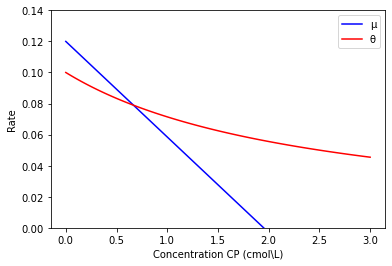

In [7]:
Cp_curve = np.linspace(0,3,100)
μ_curve = μmax * (1 - Cp_curve / Cp_star)
θ_curve = θmax * (1 + Cp_curve / Kp)**(-1)

#% matplotlib notebook 
plt.figure(1)
plt.plot(Cp_curve, μ_curve, color = 'blue', label = 'μ')
plt.plot(Cp_curve, θ_curve, color = 'red', label = 'θ')
plt.ylim([0,0.14])  #y limits on graph
plt.legend(loc = 'best')
plt.ylabel('Rate') 
plt.xlabel('Concentration CP (cmol\L)') 
plt.show()

You should see from the graph above that $\mu$ terminates at $C_P=1.95 \frac{cmol}{L}$, while $\theta$ only gradually decreases as $C_P$ increases. There will thus be a time at the end where only maintenance production of ethanol occurs, provided that sufficient substrate is left once growth has terminated. Let's integrate to see if we can observe this behaviour. The fermenter equation will be the same as before (batch fermenter):

In [8]:
def ferm_eq(t, C):
    
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]  # order of components very important 
    r = response_fun([Cx, Cs, Cg, Ce])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,
            r[1]*Cx,    
            r[2]*Cx,
            r[3]*Cx]   

We'll use the following initial conditions. $C_X^0=0.001 \frac{cmol}{L}$ and $C_S^0=\frac{120}{30} \frac{cmol}{L}$

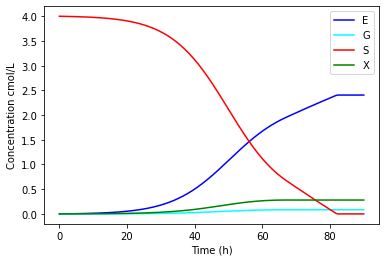

In [9]:
Co = [0.001, 120/30, 0, 0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax = 90                                    # Integrate for 20 hours  
tspan = np.linspace(0,tmax,200)           # define the timespan of the integration
Ci = solve_ivp(ferm_eq, [0, tmax], Co, t_eval = tspan, method = 'BDF')             # integration via solve_ivp that calls apon ferm_eq

Cx, Cs, Cg, Ce = Ci.y 

plt.figure(2)
plt.plot(tspan, Ce, color='blue', label = 'E')
plt.plot(tspan, Cg, color='cyan', label = 'G')
plt.plot(tspan, Cs, color='red', label = 'S')
plt.plot(tspan, Cx, color='green', label = 'X')
plt.legend(loc = 'best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('Time (h)') 
plt.show()

Interesting shapes! What is happening here? Let's have a closer look at the ethanol and biomass profiles: 

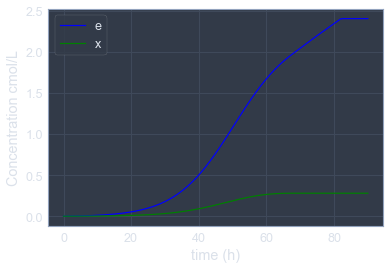

In [10]:
plt.figure(3)
plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Can you make sense out of these shapes? Let's see what happens to the glycerol?

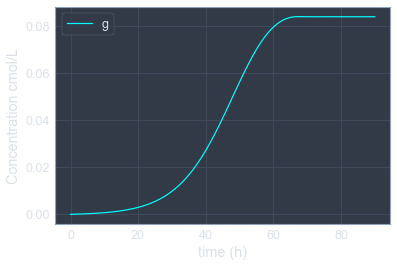

In [11]:
plt.figure(4)
plt.plot(tspan, Cg, color='cyan', label='g')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

What is happening here? Play around with the answers. More to follow in the class example on this example.

### Class questions

a) Plot $r_E$ and $r_E^V$.

This is the perfect time to introduce the CBI emojis. Watch the video below so that you understand the figure (emojis) used to explain the results of this example:

[Video: Lecture 12 CBI emojis](https://youtu.be/IBb6s8AfvJ4)

Let's plot the two graphs:


<IPython.core.display.Javascript object>


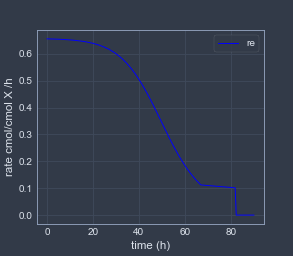

In [12]:
r = np.asarray([response_fun(C) for C in Ci.y.T])  #make sure you understand how this 'loop' works

re =r [:,3]
rev=re*Cx
#Let's try the new plotting options
%matplotlib notebook   
plt.figure(5)
plt.plot(tspan, re, color='blue', label='re')
plt.legend(loc='best')
plt.ylabel('rate cmol/cmol X /h') 
plt.xlabel('time (h)') 
plt.show()

<IPython.core.display.Javascript object>


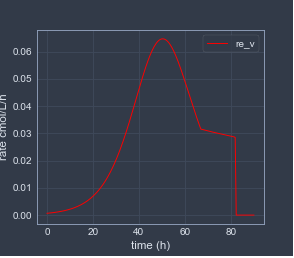

In [13]:
plt.figure(6)
plt.plot(tspan, rev, color='red', label='re_v')
plt.legend(loc='best')
plt.ylabel('rate cmol/L/h') 
plt.xlabel('time (h)') 
plt.show()

Note that the figures are interactive in the Jupyter Notebook environment. To fully understand the shapes of these two figures, watch the following video:
    
[Video: Lecture 14 Biomass and volume based rates](https://youtu.be/3yARnRAT76s)
   

For bioreactors there are 3 important rates namely $r_i$, $r_i^V$ and $P$. Productivity ($P$) has the same units as $r_i^V$ but represents an **accumulative** property. The rates $r_i$, $r_i^V$ can only be considered at a specific moment in time and are **instantaneous** properties. The video below attempts at explaining the difference between **instantaneous and accumulative rates:** 

[Video: Lecture 13 Accumulative vs instantaneous](https://youtu.be/hKow4xwdyGI)

Note that:

$$\text{Productivity (P)}=\frac{\text{amount of product made}}{\text{volume of fermenter} \cdot \text{time}} \Rightarrow \frac{g}{L \cdot h}$$


b) Plot $Y_{SE}$ in $\frac{g}{g}$ as a function of time and calculate the accumulative product yield (APY) of ethanol on glucose.

Let's start with the $Y_{SE}$ plot:

<IPython.core.display.Javascript object>


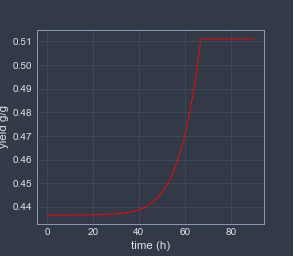

In [14]:
rs=-r[:,1]
Yse=re/rs*23/30; #g/g

plt.figure(7)
plt.plot(tspan, Yse, color='red', label='YSE')
plt.ylabel('yield g/g') 
plt.xlabel('time (h)') 
plt.show()

The interpretation of this graph is given in the following video:

[Video: Lecture 15 Yield variation](https://youtu.be/r6ziaoQW8qc)

Note that Accumulative product yield (APY) is given by:

$$\text{APY}=\frac{\text{amount of targeted product made}}{\text{amount of feedstock spent}} \Rightarrow \frac{g}{g}$$



c) Determine $r_{E}^V$ and $Y_{SE}$ at 40 minutes. Give in units $\frac{cmol}{L \cdot h}$ and $\frac{g}{g}$.

One can read off the interactive plots or alternatively quickly re-integrate:

In [15]:
tmax = 40                                    
tspan2 = np.linspace(0,tmax,200)           
Ci2 = solve_ivp(ferm_eq, [0, tmax], Co, t_eval = tspan2, method = 'BDF')

r2 = response_fun(Ci2.y.T[-1,:])     #Last row of concnetration matrix
rev2 = r2[3]*Ci2.y.T[-1,0]
Yse2 = -r2[3]/r2[1]*23/30

[rev2, Yse2]

[0.0462619968505537, 0.43886954606780354]

Check on the graphs above whether the answers are correct.

d) What is the APY and productivity of the fermentation above? [0.67 $\frac{g}{L \cdot h}$ and 0.461 $\frac{g}{g}$]

In [16]:
tdone=np.interp(0.0001,Cs[::-1],tspan[::-1]) 
P=max(Ce)/tdone*23
Y=max(Ce)/(120/30)*23/30
[P, Y]

[0.6721780880415941, 0.4610396996964462]

e) Repeat the whole fermentation but change $C_P^*$ from $1.95$ to $0.8 \; \frac{cmol}{L}$. Determine **P** and **APY** and clearly explain the differences to yourself [0.304 $\frac{g}{L \cdot h}$ & 0.492 $\frac{g}{g}$]. Increase of **APY** is 7% while **P** decrases with 55%. 

[Back to Contents page](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/List%20of%20contents.ipynb)